In [1]:
import warnings
import numpy as np
import torch
import matplotlib.pylab as plt
from pylightcurve_torch import TransitModule

# plt.rcParams['figure.figsize'] = 12,3

In [2]:
time =  torch.linspace(4,6,500)
pars =  {'e':0.05, 'i':90., 'w':0., 'rp': 0.05, 'method': 'linear', 'ldc': [0.1], 
             'P': 4., 't0': 5., 'a': 5., 'fp': 0.0001}

tm = TransitModule(time, **pars)


In [3]:
import torch.distributions as dist

class ParSampler():
    bounds = {
              't0': (-1e10, 1e10),
              'a': (0., 1e4),
              'P': (0., 1e4),
              'rp': (0., 1.),
              'fp': (0., 1.),
              'e': (0., 1.),
              'w': (0., 180.),
              'i': (0., 180.),
             }
    bounds_ldc = {'linear': [(0,1)], 
                  'sqrt': [(0., 1.), (-1., 1.)],
                  'quad': [(0., 1.), (-1., 1.)],
                  'claret': [(-1., 1.), (-1., 1.), (-1., 1.), (-1., 1.)]}
    
    def __init__(self, method='linear', locs=None, scales=None, bounds=None):
        self.method = method
        for par in self.bounds:
            loc = locs[par] if locs is not None and par in locs else None
            scale = scales[par] if scales is not None and par in scales else None
            b = bounds[par] if bounds is not None and par in bounds else None
            self.set_param(par, loc, scale, b)
            
        self.set_ldc(locs['ldc'] if locs is not None and 'ldc' in locs else None,
                     scales['ldc'] if scales is not None and 'ldc' in scales else None,
                     bounds['ldc'] if bounds is not None  and 'ldc' in bounds else None
                    )
    
    def set_param(self, name, loc=None, scale=None, bounds=None):
        
        if name == 'ldc':
            self.set_ldc(loc, scale, bounds)
            return 
        elif name in self.bounds:
            bounds = bounds if bounds else self.bounds[name]
        else:
            raise RuntimeError('unkown param')
        setattr(self, name, Param(name, loc, scale, bounds))
    
    def set_ldc(self, loc=None, scale=None, bounds=None):
        ldc_dim = len(self.bounds_ldc[self.method])
        if loc is not None:
            assert len(loc) == ldc_dim
        else:
            loc = [None] * ldc_dim
        if scale is not None:
            assert len(scale) == ldc_dim
        else:
            scale = [None] * ldc_dim
        if bounds is not None:
            assert len(bounds) == ldc_dim
        else:
            bounds = self.bounds_ldc[self.method]
        for i in range(ldc_dim):
            setattr(self, 'ldc_'+str(i), Param('ldc_'+str(i), loc[i], scale[i], bounds[i]))
    
    def sample_ldc(self):
        ldc_dim = len(self.bounds_ldc[self.method])
        out = [None] * ldc_dim
        for i in range(ldc_dim):
            out[i] = getattr(self, 'ldc_'+str(i)).sample()
        return out
    
    def sample(self):
        out = dict()
        for par in self.bounds:
            out[par] = getattr(self, par).sample()
        out['ldc'] = self.sample_ldc()
        return out
    
    @property
    def ldc(self):
        return [getattr(self, 'ldc_'+str(i)) for i in range(len(self.bounds_ldc[self.method]))]
            
    def __repr__(self):
        return 'ParSampler(' + ',\n\t   '.join([str(getattr(self, par)) for par in self.bounds]
                                               + [str(ldc) for ldc in self.ldc]) + ')'
            
class Param():
    def __init__(self, name, loc=None, scale=None, bounds=None):
        self.name = name
        self.loc = loc
        if bounds is not None and self.loc is not None:
            assert bounds[0] < self.loc < bounds[1]
        self.scale = scale
        self.bounds = bounds
    
    def sample(self):
        if self.loc is not None and self.scale is not None:
            out = dist.Normal(self.loc, self.scale).sample()
            if self.bounds is not None:
                warnings.warn('out of bounds')
                out = out.clamp(*self.bounds)
            return out
        elif self.bounds is not None:
            return dist.Uniform(*self.bounds).sample()
        elif self.loc is not None:
            return self.loc
        else:
            raise RuntimeError("couldn't sample because of missing params")
            
    def __repr__(self):
        return (f"Param('{self.name}'"
                + (f', loc={self.loc}' if self.loc is not None else '')
                + (f', scale={self.scale}'if self.scale is not None else '')
                + (f', bounds={self.bounds}' if self.bounds is not None else '')
                + ')')

In [4]:
ps = ParSampler(method='sqrt', bounds={'t0':(-10,10), 'P':(0, 10)})
ps

ParSampler(Param('t0', bounds=(-10, 10)),
	   Param('a', bounds=(0.0, 10000.0)),
	   Param('P', bounds=(0, 10)),
	   Param('rp', bounds=(0.0, 1.0)),
	   Param('fp', bounds=(0.0, 1.0)),
	   Param('e', bounds=(0.0, 1.0)),
	   Param('w', bounds=(0.0, 180.0)),
	   Param('i', bounds=(0.0, 180.0)),
	   Param('ldc_0', bounds=(0.0, 1.0)),
	   Param('ldc_1', bounds=(-1.0, 1.0)))

In [5]:
ps.sample()

{'t0': tensor(6.6477),
 'a': tensor(3297.1497),
 'P': tensor(0.0863),
 'rp': tensor(0.9850),
 'fp': tensor(0.4746),
 'e': tensor(0.6091),
 'w': tensor(118.5142),
 'i': tensor(1.7685),
 'ldc': [tensor(0.2747), tensor(0.2091)]}

In [6]:
tm._parnames

['method', 'P', 'i', 'e', 'a', 'rp', 'fp', 't0', 'w', 'ldc']

In [7]:
#tm.set_param(e=0.1)

In [10]:
tm.activate_grad('w')
tm.rp, tm.e

(Parameter containing:
 tensor([[0.0500]], dtype=torch.float64),
 Parameter containing:
 tensor([[0.0500]], dtype=torch.float64))

In [11]:
obs_flux = tm(rp=tm.rp + torch.distributions.Normal(0,tm.rp/10).sample()).detach()
initial_flux = tm().detach()

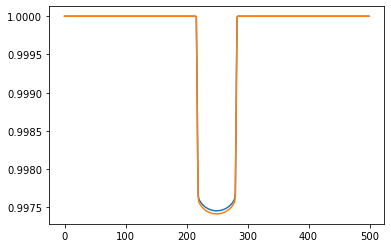

In [12]:
plt.plot(obs_flux.T.detach())
plt.plot(initial_flux.T.detach())

In [13]:
optimizer = torch.optim.SGD(tm.parameters(), lr=0.1)

In [14]:
tm.train()
for step in range(2):
    print(tm.e, tm.rp, tm.w)
    optimizer.zero_grad()
    loss = tm().mean()
    
    loss.backward()
    print("loss", loss)
    
    optimizer.step()

Parameter containing:
tensor([[0.0500]], dtype=torch.float64) Parameter containing:
tensor([[0.0500]], dtype=torch.float64) Parameter containing:
tensor([[0.]], dtype=torch.float64, requires_grad=True)
loss tensor(0.9997, dtype=torch.float64, grad_fn=<MeanBackward0>)
Parameter containing:
tensor([[0.0500]], dtype=torch.float64) Parameter containing:
tensor([[0.0500]], dtype=torch.float64) Parameter containing:
tensor([[-2.8896e-08]], dtype=torch.float64, requires_grad=True)
loss tensor(0.9997, dtype=torch.float64, grad_fn=<MeanBackward0>)
